In [1]:
import sys
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as sp_io
import matplotlib.pyplot as plt
import intake_esm, intake
import seaborn as sns
from matplotlib.colors import ListedColormap
import xarray as xr
colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)


In [2]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data 

def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [3]:
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               #  member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=['GFDL-ESM4'],
                 grid_label=['gn'],
                 variable_id=["areacello"])

cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx) 
cat_Ofx_lat = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)
dset_dict_Ofx = cat_Ofx_lat.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})

ds2 = dset_dict_Ofx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [4]:
kCluster6 = "/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/GFDL-ESM4/GFDL-ESM4-Historical-187201-201112-EnsembleMLP.npy"

In [5]:
areaGlobal = ds2.areacello

In [6]:
labels2=np.load(kCluster6)

In [7]:
labels2.shape

(7, 576, 720)

In [8]:
#plt.imshow(np.flip(labels2[1][:][:]==5))

Plot all regime data 

<Figure size 432x288 with 0 Axes>

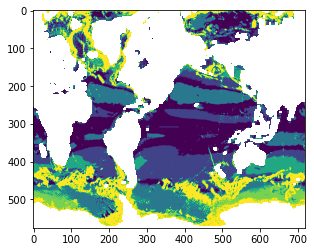

<Figure size 432x288 with 0 Axes>

In [9]:
# First we check that they look OK, and have the same orientation.
plt.imshow(np.flip(labels2[0][:][:]))
plt.figure()

### Original pseudo code

def creaCalc(data, areaData):

    Get data and areaData into numpy arrays

    Calculate area for the data for all the regimes

    (This will be an array where only the areas that are covered by the different dynamical regimes are non-nan)

    return areaDataRegime0, areaDataRegime1, areaDataRegime2, areaDataRegime3, areaDataRegime4, areaDataRegime5

In [10]:
def extractionAreaCalc(data, area,chunks=None):
    """Code to extract area of different regimes. In principle this is applicable to any field, not just the area."""
    '''
    input:
    data is the labelled regime data 
    area is the total area
    output:
    mask matrix, indexed by regime labels 0 to 5
    '''
    regimeData=np.array(data)         #May have to add selection of specific data
    areaData=np.array(area)           #May have to add selection of specific data
   # print(areaData.shape)
    #Create dummy variable
    Msk=np.zeros((6,chunks, data.shape[1], data.shape[2]))
    for chunk in np.arange(0,chunks): #this will run for 7 chunks of 20 years
        for regime in np.arange(0,6):     # Loop over regimes
            regimeIndexes=np.where(regimeData[chunk]!=regime)   # Determine where regimes are *NOT* present
            areaSelected=np.copy(areaData[0])
            areaSelected[regimeIndexes]=-9999 # Set areas there the regime is not present to zero. Can be np.nan too, but I'm not sure what will caouse the least trouble!
            Msk[regime][chunk]=areaSelected      # Slot into results matrix
           # plt.figure()                  # Can be commented out
           # plt.title("Chunk-"+(str)(chunk)+"-- Area of regime "+(str)(regime))
            #plt.imshow(np.rot90(Msk[regime][chunk])) #*land,1))       # Can be commented out
            #print(areaSelected[(areaSelected>0)])
            #print("test",Msk[regime][chunk][Msk[regime][chunk] > 0])
    return Msk                        # Decided to return one matric instead of 6 fields

#todo concatenate chunks in regimeData

In [11]:
labels2.shape

(7, 576, 720)

In [12]:
areaData=np.array(areaGlobal)
Mask=extractionAreaCalc(labels2, areaGlobal,chunks=7)

In [13]:
Mask.shape

(6, 7, 576, 720)

In [14]:
labels2.shape

(7, 576, 720)

In [15]:
#new_labels2=np.zeros((1, labels2[0][:][:].shape[0], labels2[0][:][:].shape[1]))

#new_labels2[0] = labels2[0][:]

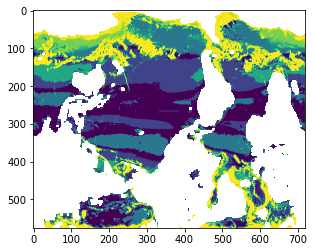

In [16]:
plt.imshow(labels2[0])

In [17]:
da_regimeData = xr.DataArray(
        data=labels2,
        dims=["chunk","y", "x"],
)


In [18]:
da_regimeData.shape

(7, 576, 720)

In [19]:
ds = xr.Dataset(
     data_vars=dict(
        regimeData=(["chunk","y","x"], da_regimeData),
        areaGlobal=(ds2.areacello),
        mask=(["regimeIndex","chunk","y", "x"], Mask),
    ),
     coords=dict(
         x=(ds2.x),
         y=(ds2.y),
         chunk=[0, 1, 2 , 3 , 4, 5, 6]
     )
)

In [20]:
ds

<xarray.Dataset>
Dimensions:     (chunk: 7, member_id: 1, regimeIndex: 6, x: 720, y: 576)
Coordinates:
    lat         (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon         (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * x           (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y           (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * member_id   (member_id) <U8 'r1i1p1f1'
  * chunk       (chunk) int64 0 1 2 3 4 5 6
Dimensions without coordinates: regimeIndex
Data variables:
    regimeData  (chunk, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    areaGlobal  (member_id, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    mask        (regimeIndex, chunk, y, x) float64 -9.999e+03 ... -9.999e+03

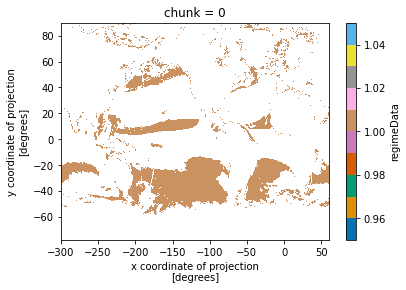

In [21]:
ds.regimeData[0].where(ds.regimeData[0] == 1).plot(cmap=my_cmap)

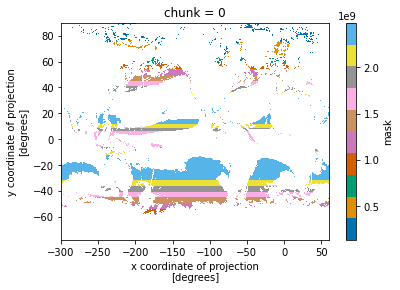

In [22]:
ds.mask[1][0].where(ds.mask[1][0] != -9999).plot(cmap=my_cmap)#        mask=(["regimeIndex","chunk","y", "x"], Mask),


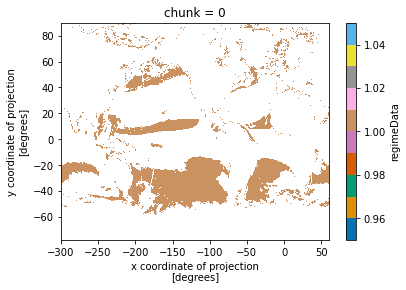

In [23]:
ds.regimeData[0].where(ds.regimeData[0] == 1).plot(cmap=my_cmap)

In [24]:
regime_nino3 = ds.regimeData.sel(y = slice(-5,5), x = slice(-150, -90))

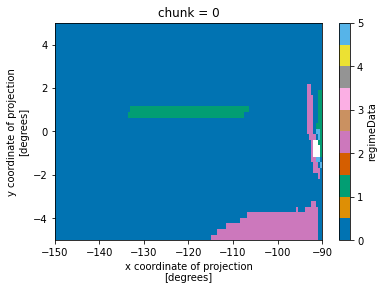

In [25]:
regime_nino3[0].plot(cmap=my_cmap)

In [26]:
mask_nino3 = ds.mask.sel(y = slice(-5,5), x = slice(-150, -90))


In [27]:
mask_nino3.shape

(6, 7, 39, 120)

In [28]:
area_sum = np.zeros((3, 6))

In [29]:
#ds.mask[1][0].where(ds.mask[1][0] != -1).sel(y = slice(-5,5), x = slice(-150, -90)).plot()
c = 0
for chunk in np.arange(4,7):
    for regime in np.arange(0,6): 
        #plt.figure()
        mask_nino3_regime = ds.mask[regime][chunk].where(ds.mask[regime][chunk] != -9999).sel(y = slice(-5,5), x = slice(-150, -90))
        #mask_nino3_regime.plot()
        avgarea = mask_nino3_regime.sum(dim=('x', 'y'))
        area_sum[c][regime] = avgarea
        #plt.title("Regime:"+(str)(regime)+"Average area:"+(str)(avgarea))
    c+=1


In [30]:
print ("Mean and std of 7 chunks of 20 years")
mean_his=np.zeros(6)
std_his=np.zeros(6)
for regime in range(0,6):
    all_chuncks = np.zeros(3)
    for yrs in range(0,3):
        all_chuncks[yrs] = area_sum[yrs][regime]
    mean_his[regime], std_his[regime] = all_chuncks.mean(), all_chuncks.std()
    print("mean= ", "{:e}".format(all_chuncks.mean()), "std= ", "{:e}".format(all_chuncks.std()))

Mean and std of 7 chunks of 20 years
mean=  6.916359e+12 std=  1.128402e+10
mean=  1.757886e+11 std=  3.959768e+09
mean=  3.126645e+11 std=  1.472449e+10
mean=  0.000000e+00 std=  0.000000e+00
mean=  0.000000e+00 std=  0.000000e+00
mean=  7.941738e+09 std=  0.000000e+00


## 1%CO2

In [31]:
labels_1pct = np.load("/home/jovyan/DNN4Cli/figures/ESM4/ESM4-1pctCO2-000101-014012-EnsembleMLP.npy")

In [32]:
labels_1pct.shape

(7, 576, 720)

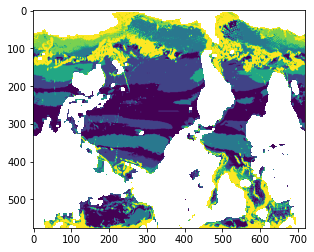

In [33]:
plt.imshow(labels_1pct[0])

In [34]:
Mask_1pct=extractionAreaCalc(labels_1pct, areaGlobal,chunks=7)

In [35]:
#new_labels_1pct=np.zeros((1, labels_1pct.shape[1], labels_1pct.shape[2]))

#new_labels_1pct = labels_1pct[:]

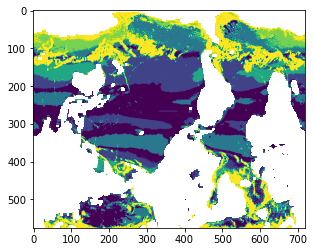

In [36]:
plt.imshow(labels_1pct[2])

In [37]:
da_regimeData_1pct = xr.DataArray(
        data=labels_1pct,
        dims=["chunk","y", "x"],
)

In [38]:
ds_1pct = xr.Dataset(
     data_vars=dict(
        regimeData=(["chunk","y","x"], da_regimeData_1pct),
        areaGlobal=(ds2.areacello),
        mask=(["regimeIndex","chunk","y", "x"], Mask_1pct),
    ),
     coords=dict(
         x=(ds2.x),
         y=(ds2.y),
         chunk=range(7)
     )
)

In [39]:
ds_1pct

<xarray.Dataset>
Dimensions:     (chunk: 7, member_id: 1, regimeIndex: 6, x: 720, y: 576)
Coordinates:
    lat         (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon         (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * x           (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y           (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * member_id   (member_id) <U8 'r1i1p1f1'
  * chunk       (chunk) int64 0 1 2 3 4 5 6
Dimensions without coordinates: regimeIndex
Data variables:
    regimeData  (chunk, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    areaGlobal  (member_id, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    mask        (regimeIndex, chunk, y, x) float64 -9.999e+03 ... -9.999e+03

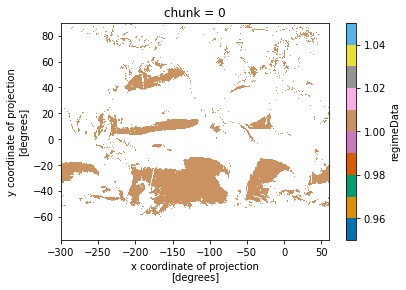

In [40]:
ds_1pct.regimeData[0].where(ds_1pct.regimeData[0] == 1).plot(cmap = my_cmap)

In [41]:
regime_nino3_1pct = ds_1pct.regimeData.sel(y = slice(-5,5), x = slice(-150, -90))

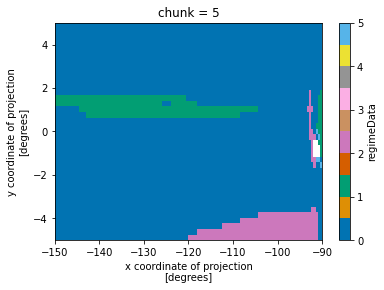

In [42]:
regime_nino3_1pct[5].plot(cmap=my_cmap)

In [43]:
area_sum_1pct = np.zeros((3,6))

In [44]:
c = 0
for chunk in np.arange(4,7):
    for regime in np.arange(0,6): 
        #plt.figure()
        mask_nino3_regime_1pct = ds_1pct.mask[regime][chunk].where(ds_1pct.mask[regime][chunk] != -9999).sel(y = slice(-5,5), x = slice(-150, -90))
        #mask_nino3_regime.plot()
        avgarea = mask_nino3_regime_1pct.sum(dim=('x', 'y'))
        area_sum_1pct[c][regime] = avgarea
        #plt.title("Regime:"+(str)(regime)+"Average area:"+(str)(avgarea))
    c+=1

In [45]:
print ("Mean and std of 3 chunks of 20 years")
mean_1pct = np.zeros(6)
std_1pct = np.zeros(6)
for regime in range(0,6):
    all_chuncks = np.zeros(7)
    for yrs in range(0,3):
        all_chuncks[yrs] = area_sum_1pct[yrs][regime]
    mean_1pct[regime], std_1pct[regime] = all_chuncks.mean(), all_chuncks.std()
    print("mean= ", "{:e}".format(all_chuncks.mean()), "std= ", "{:e}".format(all_chuncks.std()))


Mean and std of 3 chunks of 20 years
mean=  2.845594e+12 std=  3.286027e+12
mean=  1.620106e+11 std=  1.931602e+11
mean=  1.658861e+11 std=  1.920101e+11
mean=  0.000000e+00 std=  0.000000e+00
mean=  0.000000e+00 std=  0.000000e+00
mean=  3.403602e+09 std=  3.930141e+09


## Abrupt-4xCO2

In [46]:
labels_4x = np.load("/home/jovyan/DNN4Cli/figures/ESM4/ESM4-abrupt4xCO2-000101-014012-EnsembleMLP.npy")

In [47]:
labels_4x.shape

(7, 576, 720)

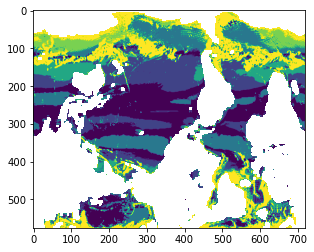

In [48]:
plt.imshow(labels_4x[0])

In [49]:
Mask_4x = extractionAreaCalc(labels_4x, areaGlobal,chunks=7)

In [50]:
Mask_4x.shape

(6, 7, 576, 720)

In [51]:
#new_labels_4x=np.zeros((1, labels_4x[0][:][:].shape[0], labels_4x[0][:][:].shape[1]))

#new_labels_4x[0] = labels_4x[0][:]

In [52]:
da_regimeData_4x = xr.DataArray(
        data=labels_4x,
        dims=["chunk","y", "x"],
)

In [53]:
ds_4x = xr.Dataset(
     data_vars=dict(
        regimeData=(["chunk","y","x"], da_regimeData_4x),
        areaGlobal=(ds2.areacello),
        mask=(["regimeIndex","chunk","y", "x"], Mask_4x),
    ),
     coords=dict(
         x=(ds2.x),
         y=(ds2.y),
         chunk=np.arange(7)
     )
)

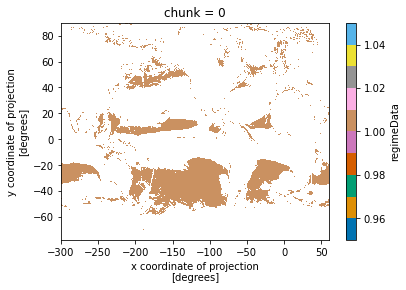

In [54]:
ds_4x.regimeData[0].where(ds_4x.regimeData[0] == 1).plot(cmap=my_cmap)

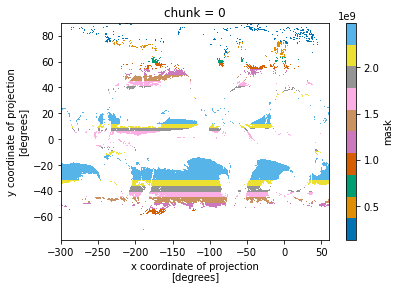

In [55]:
ds_4x.mask[1][0].where(ds_4x.mask[1][0] != -9999).plot(cmap=my_cmap)#        mask=(["regimeIndex","chunk","y", "x"], Mask),


In [56]:
regime_nino3_4x = ds_4x.regimeData.sel(y = slice(-5,5), x = slice(-150, -90))

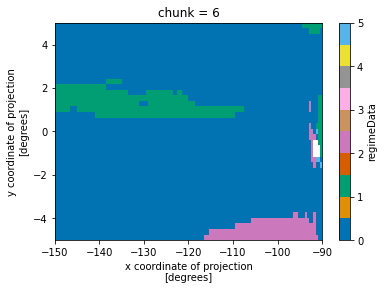

In [57]:
regime_nino3_4x[6].plot(cmap=my_cmap)

In [58]:
area_sum_4x =np.zeros((3,6))

In [59]:
c=0
for chunk in np.arange(4,7):
    for regime in np.arange(0,6): 
        #plt.figure()
        mask_nino3_regime_4x = ds_4x.mask[regime][chunk].where(ds_4x.mask[regime][chunk] != -9999).sel(y = slice(-5,5), x = slice(-150, -90))
        #mask_nino3_regime.plot()
        avgarea = mask_nino3_regime_4x.sum(dim=('x', 'y'))
        area_sum_4x[c][regime] = avgarea
        #plt.title("Regime:"+(str)(regime)+"Average area:"+(str)(avgarea))
    c+=1


In [63]:
area_sum_4x

array([[6.55130352e+12, 4.93931398e+11, 3.59577491e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.44642485e+12, 6.51106773e+11, 3.07280787e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.52418795e+12, 5.97111484e+11, 2.85101598e+11, 0.00000000e+00,
        0.00000000e+00, 6.35311053e+09]])

In [64]:
print ("Mean and std of 7 chunks of 20 years")
mean_4x = np.zeros(6)
std_4x = np.zeros(6)
for regime in range(0,6):
    all_chuncks = np.zeros(7)
    for yrs in range(0,3):
        all_chuncks[yrs] = area_sum_4x[yrs][regime]
    mean_4x[regime], std_4x[regime] = all_chuncks.mean(), all_chuncks.std()
    print("mean= ", "{:e}".format(all_chuncks.mean()), "std= ", "{:e}".format(all_chuncks.std()))

Mean and std of 7 chunks of 20 years
mean=  2.788845e+12 std=  3.220413e+12
mean=  2.488785e+11 std=  2.905332e+11
mean=  1.359943e+11 std=  1.583573e+11
mean=  0.000000e+00 std=  0.000000e+00
mean=  0.000000e+00 std=  0.000000e+00
mean=  3.176655e+09 std=  3.700704e+09


In [91]:
import pandas as pd

In [120]:
df = pd.DataFrame({"Mean_his": mean_his,
                  "Std_his": std_his,
                  "Mean_1%": mean_1pct,
                  "Std_1%": std_1pct,
                  "Mean_4x": mean_4x,
                  "Std_4x": std_4x
                 })
df

,Mean_his,Std_his,Mean_1%,Std_1%,Mean_4x,Std_4x
0,6.916359e+12,1.128402e+10,2.845594e+12,3.286027e+12,2.788845e+12,3.220413e+12
1,1.757886e+11,3.959768e+09,1.620106e+11,1.931602e+11,2.488785e+11,2.905332e+11
2,3.126645e+11,1.472449e+10,1.658861e+11,1.920101e+11,1.359943e+11,1.583573e+11
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,7.941738e+09,0.000000e+00,3.403602e+09,3.930141e+09,3.176655e+09,3.700704e+09


In [65]:
area_sum_1pct

array([[6.70858328e+12, 2.81148585e+11, 4.15080537e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.56717559e+12, 4.59037830e+11, 3.78598983e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.64340078e+12, 3.93888129e+11, 3.67523496e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09]])

In [66]:
area_sum_4x

array([[6.55130352e+12, 4.93931398e+11, 3.59577491e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.44642485e+12, 6.51106773e+11, 3.07280787e+11, 0.00000000e+00,
        0.00000000e+00, 7.94173811e+09],
       [6.52418795e+12, 5.97111484e+11, 2.85101598e+11, 0.00000000e+00,
        0.00000000e+00, 6.35311053e+09]])

In [60]:
MD = area_sum_1pct[:,0]

S_NV =area_sum_1pct[:,1]

N_NV = area_sum_1pct[:,2]

TR = area_sum_1pct[:,5]
areass = [MD, S_NV, N_NV, TR]

In [61]:
MD4x = area_sum_4x[:,0]
S_NV4x =area_sum_4x[:,1]
N_NV4x = area_sum_4x[:,2]
TR4x = area_sum_4x[:,5]
areass4x = [MD4x, S_NV4x, N_NV4x, TR4x]

In [62]:
areass

[array([6.70858328e+12, 6.56717559e+12, 6.64340078e+12]),
 array([2.81148585e+11, 4.59037830e+11, 3.93888129e+11]),
 array([4.15080537e+11, 3.78598983e+11, 3.67523496e+11]),
 array([7.94173811e+09, 7.94173811e+09, 7.94173811e+09])]

In [63]:
areass4x

[array([6.55130352e+12, 6.44642485e+12, 6.52418795e+12]),
 array([4.93931398e+11, 6.51106773e+11, 5.97111484e+11]),
 array([3.59577491e+11, 3.07280787e+11, 2.85101598e+11]),
 array([7.94173811e+09, 7.94173811e+09, 6.35311053e+09])]

In [64]:
labels = ['Area MD', 'Area SSV', 'Area NSV', 'Area NL'
         ]

In [65]:
area_sum = area_sum[2].tolist()


In [73]:
area_sum

[6922708820096.0, 174731745024.0, 307371841536.0, 7941738112.0]

In [74]:
#area_sum.pop(3)

In [75]:
area_sum

[6922708820096.0, 174731745024.0, 307371841536.0, 7941738112.0]

In [69]:
labels

['Area MD', 'Area SSV', 'Area NSV', 'Area NL']

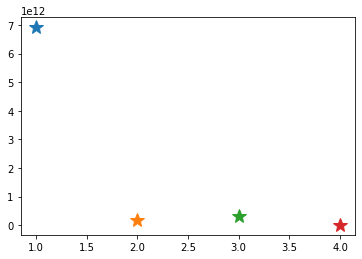

In [78]:
plt.plot(1, area_sum[0],'*', markersize=15)
plt.plot(2, area_sum[1],'*', markersize=15)
plt.plot(3, area_sum[2],'*', markersize=15)
plt.plot(4, area_sum[3],'*', markersize=15)

<ipython-input-90-0054a318c980>:31: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7ff26c9dd3d0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([hist, bplot1["boxes"][0], bplot2["boxes"][0]], ["Historical",'1%CO'+'\N{SUBSCRIPT TWO}', '4xCO'+'\N{SUBSCRIPT TWO}'], loc='upper right')


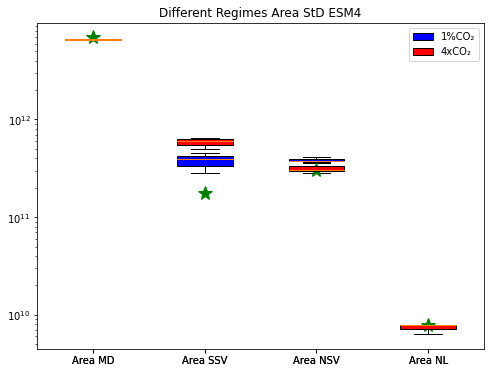

In [90]:
plt.figure(figsize=(8,6))
bplot1 = plt.boxplot(areass,
                      vert=True,  # vertical box alignment
                  patch_artist=True,# fill with color
                     widths = 0.5,
                labels=labels) 
bplot2 = plt.boxplot(areass4x,
                      vert =True,  # vertical box alignment
                  patch_artist=True,# fill with color
                     widths = 0.5,
                labels=labels)
#plothis = plt.plot(labels, area_sum, '*', "green")
plt.plot(1, area_sum[0],'*', markersize=15,color = "green")
plt.plot(2, area_sum[1],'*', markersize=15 ,color = "green")
plt.plot(3, area_sum[2],'*', markersize=15,color = "green")
hist = plt.plot(4, area_sum[3],'*', markersize=15,color = "green")

plt.yscale('log')
#plt.ylim (9.0e+11, 6.0e+12)
#(['A simple line'])
colors = ['darkblue','green', 'pink', 'lightblue']
colors = ["blue", "blue", "blue", "blue"]
#for bplot in (bplot1, bplot2):
    #for patch, color in zip(bplot['boxes'], colors):
        #patch.set_facecolor(color)
for patch in bplot1["boxes"]:
    patch.set(facecolor = 'blue')
for patch in bplot2["boxes"]:
    patch.set(facecolor = 'red')
plt.title("Different Regimes Area StD ESM4")
plt.legend([hist, bplot1["boxes"][0], bplot2["boxes"][0]], ["Historical",'1%CO'+'\N{SUBSCRIPT TWO}', '4xCO'+'\N{SUBSCRIPT TWO}'], loc='upper right')
plt.show()

#plt.ylim (10.0e+11,)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lon_nino3 = ds2["x"][(ds2["x"] > -150)  & (ds2["x"] < -90)]
lat_nino3 = ds2["y"][(ds2["y"] > -5)  & (ds2["y"] < 5)]

plt.figure(figsize=(6, 3))
plt.title('gfdl-esm4-regimes')

ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_global()
ax2.coastlines()

ax2.contourf(lon_nino3,lat_nino3,regime_nino3[0],cmap='cmo.phase')  # didn't use transform, but looks ok...

plt.show()

ax2.set_global()
ax2.coastlines();
